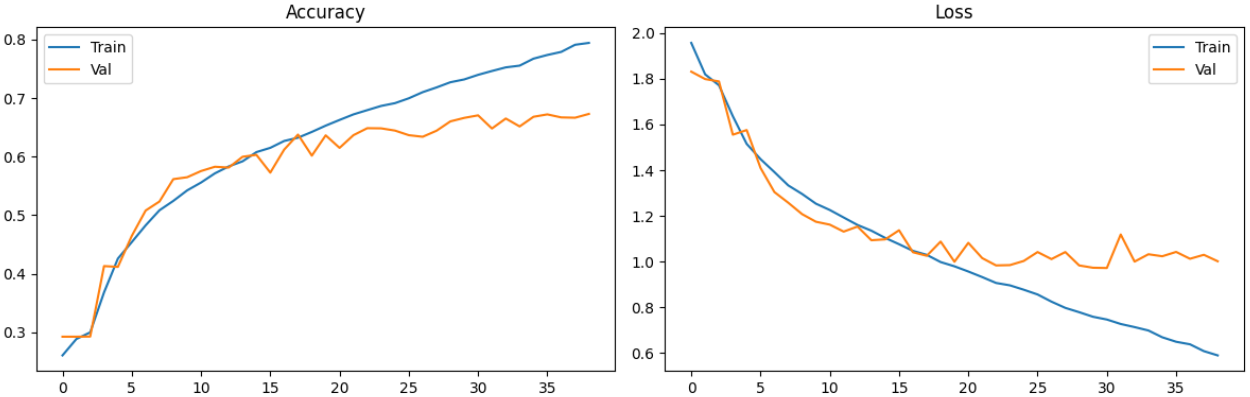

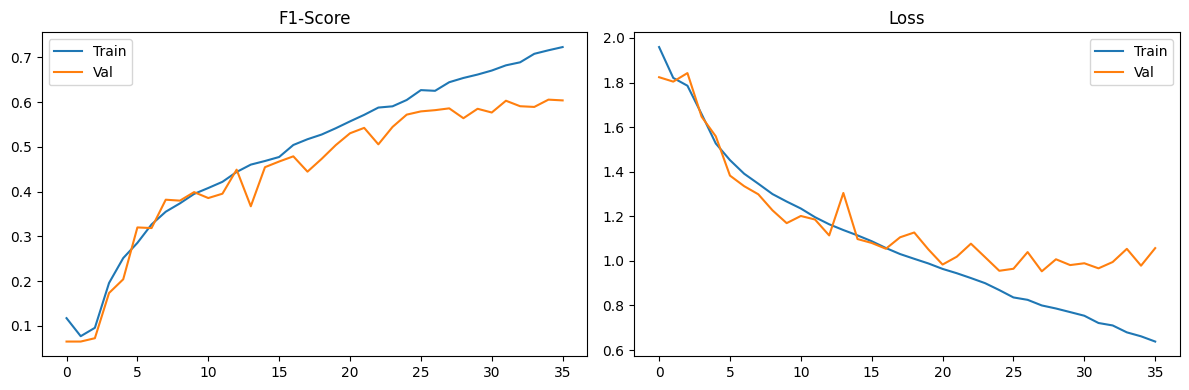

### Ao utilizar o F1-Score e treinar o algoritmo com essa métrica, podemos ver que o algoritmo desempenhou pior quando comparado com a utilização da Acurácia. Como estamos lidando com uma base de dados desbalanceada, é mais interessante utilizar o F1-Score visto que ele não favorece classes maiores (happy, neutral). 
### Além disso, utilizando a acurácia como métrica de avaliação pode indicar um desempenho "falso", visto que como ele favorece classes maiores, a acurácia pode ser muito alta mesmo com desempenho ruim nas classes minoritárias.
### E importante salientar que utilizando o F1-Score ele retorna um array tensor no treinamento, com 7 valores (F1-Score de cada classe), para isso, talvez seria melhor também implementar o F1-Score Macro, que calcula o F1 de cada classe e faz a média para retornar apenas um valor.

## ============================================================

## Etapa 1 - Importando as bibliotecas

In [ ]:
#%pip install tensorflow

In [ ]:
#%pip install numpy pandas matplotlib opencv-python scikit-learn, seaborn
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import do Google Colab: from google.colab.patches import cv2_imshow

In [3]:
import tensorflow
tf.__version__

'2.19.0'

## Etapa 2 - Acessando a base FER-2013 + RAF-DB com fotos de expressões faciais

In [ ]:
import os
base_path = "C:/Users/guilh/Downloads/fer2013/fer2013/train"
for class_name in os.listdir(base_path):
    print(class_name, "->", len(os.listdir(os.path.join(base_path, class_name))))

In [ ]:
# APÓS ADICIONAR A BASE RAF-DB
paths = []
train_path = "C:/Users/guilh/Downloads/fer2013/fer2013/train/"
val_path = "C:/Users/guilh/Downloads/fer2013/fer2013/validation/"

paths.append(train_path)
paths.append(val_path)

for class_name in os.listdir(base_path):
    train_count = len(os.listdir(os.path.join(train_path, class_name)))
    val_count = len(os.listdir(os.path.join(val_path, class_name)))
    print(f"{class_name} -> Conjunto de Treino: {train_count}; Conjunto de Validação: {val_count}")

## Etapa 3 - Analisando os dados da base

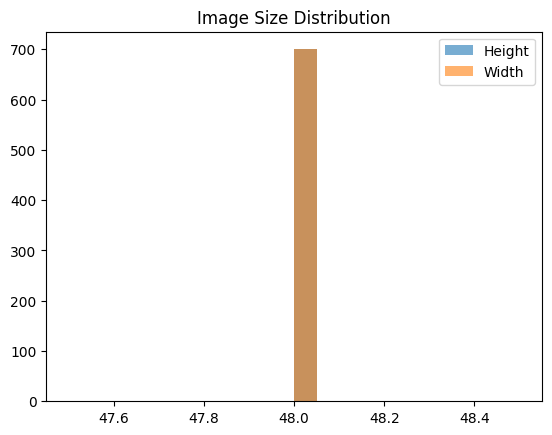

In [9]:
heights = []
widths = []

for class_folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, class_folder)
    for img_file in os.listdir(folder_path)[:100]:  # Sample 100
        img = cv2.imread(os.path.join(folder_path, img_file))
        h, w, _ = img.shape
        heights.append(h)
        widths.append(w)

plt.hist(heights, bins=20, alpha=0.6, label="Height")
plt.hist(widths, bins=20, alpha=0.6, label="Width")
plt.legend()
plt.title("Image Size Distribution")
plt.show()

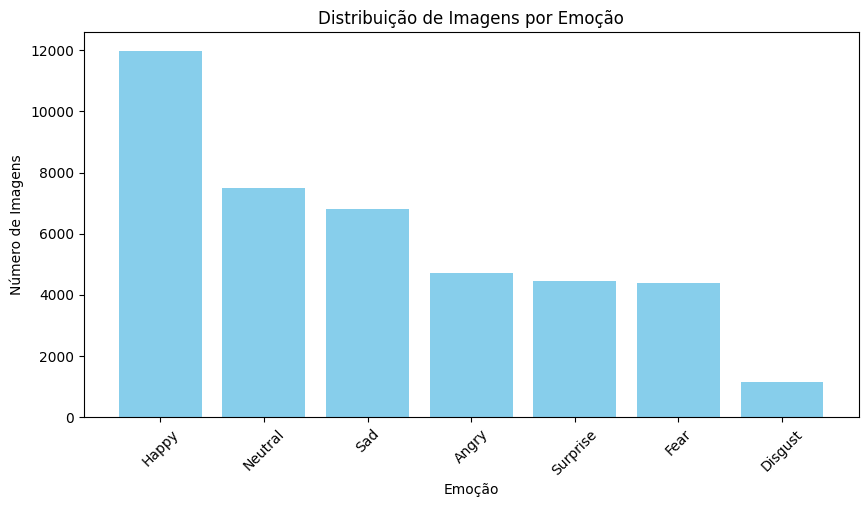

In [10]:
# Analisando a distribuição de imagens por emoção
emocoes = []
for class_name in os.listdir(base_path):
    emocoes.append((class_name, len(os.listdir(os.path.join(base_path, class_name)))))
emocoes.sort(key=lambda x: x[1], reverse=True)
plt.figure(figsize=(10, 5))
plt.bar([x[0] for x in emocoes], [x[1] for x in emocoes], color='skyblue')
plt.title('Distribuição de Imagens por Emoção')
plt.xlabel('Emoção')
plt.ylabel('Número de Imagens')
plt.xticks(rotation=45)
plt.show()

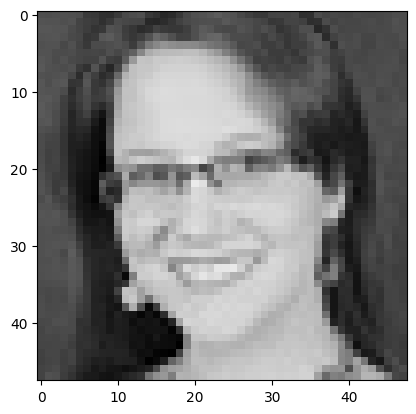

In [11]:
img_path = os.path.join(base_path, 'Happy', os.listdir(os.path.join(base_path, 'Happy'))[0])
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

## Etapa 4 - Gerando o dataset para o algoritmo

In [ ]:
def create_emotion_dataset(base_path, emotions):
    dataset = []
    for emotion in emotions:
        emotion_path = os.path.join(base_path, emotion)
        if os.path.exists(emotion_path):
            for img_file in os.listdir(emotion_path):
                img_path = os.path.join(emotion_path, img_file)
                dataset.append((img_path, emotion))
    return dataset

emotions = ['Happy', 'Sad', 'Angry', 'Surprise', 'Neutral', 'Disgust', 'Fear']
emotion_dataset = create_emotion_dataset(base_path, emotions)

In [13]:
emotion_dataset

[('C:/Users/guilh/Downloads/fer2013/fer2013/train\\Happy\\0.jpg', 'Happy'),
 ('C:/Users/guilh/Downloads/fer2013/fer2013/train\\Happy\\1.jpg', 'Happy'),
 ('C:/Users/guilh/Downloads/fer2013/fer2013/train\\Happy\\10.jpg', 'Happy'),
 ('C:/Users/guilh/Downloads/fer2013/fer2013/train\\Happy\\100.jpg', 'Happy'),
 ('C:/Users/guilh/Downloads/fer2013/fer2013/train\\Happy\\1000.jpg', 'Happy'),
 ('C:/Users/guilh/Downloads/fer2013/fer2013/train\\Happy\\1001.jpg', 'Happy'),
 ('C:/Users/guilh/Downloads/fer2013/fer2013/train\\Happy\\1002.jpg', 'Happy'),
 ('C:/Users/guilh/Downloads/fer2013/fer2013/train\\Happy\\1003.jpg', 'Happy'),
 ('C:/Users/guilh/Downloads/fer2013/fer2013/train\\Happy\\1004.jpg', 'Happy'),
 ('C:/Users/guilh/Downloads/fer2013/fer2013/train\\Happy\\1005.jpg', 'Happy'),
 ('C:/Users/guilh/Downloads/fer2013/fer2013/train\\Happy\\1006.jpg', 'Happy'),
 ('C:/Users/guilh/Downloads/fer2013/fer2013/train\\Happy\\1007.jpg', 'Happy'),
 ('C:/Users/guilh/Downloads/fer2013/fer2013/train\\Happy\\100

## Etapa 5 - Imports do Tensorflow/Keras

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.utils import plot_model, to_categorical

## Etapa 6 - Dividir em conjuntos para treinamento e validação

In [15]:
# Extrai caminhos e rótulos do dataset
X = [item[0] for item in emotion_dataset]
y = [item[1] for item in emotion_dataset]

# Divide em treino, teste e validação
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=41, stratify=y_train)

In [16]:
print('Número de imagens no conjunto de treinamento:', len(X_train))
print('Número de imagens no conjunto de teste:', len(X_test))
print('Número de imagens no conjunto de validação:', len(X_val))

Número de imagens no conjunto de treinamento: 33193
Número de imagens no conjunto de teste: 4098
Número de imagens no conjunto de validação: 3689


## Etapa 7 - Arquitetura do Modelo (CNN)

In [5]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
width, height = 48, 48

model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3,3), activation='relu',
                 input_shape=(width, height, 1), data_format = 'channels_last',
                 kernel_regularizer = l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation = 'softmax'))

model.summary()

C:\Users\guilh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 23, 23, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 23, 23, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 23, 23, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 23, 23, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 11, 11, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 11, 11, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 5, 5, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 5, 5, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 5, 5, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 5, 5, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,905,863 (22.53 MB)

 Trainable params: 5,902,151 (22.51 MB)

 Non-trainable params: 3,712 (14.50 KB)

In [ ]:
plot_model(model, to_file='model_architecture.png', 
           show_shapes=True, 
           show_layer_names=True,
           expand_nested=True, 
           rankdir='LR', 
           dpi=100)

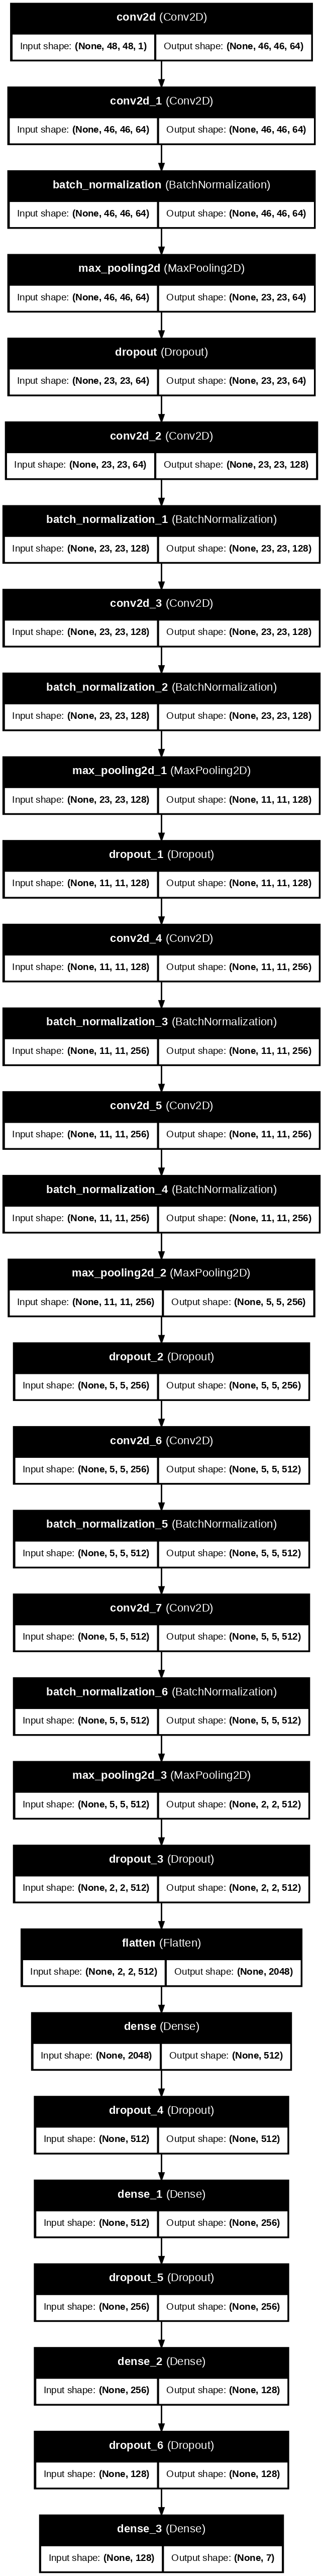

## Etapa 8 - Compilando o modelo

In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(learning_rate = 0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics = ['accuracy'])

arquivo_modelo = 'modelo_01_expressoes.h5'
arquivo_modelo_json = 'modelo_01_expressoes.json'

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor = 0.9, patience=3, verbose = 1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience = 8, verbose = 1, mode = 'auto')
checkpointer = ModelCheckpoint(arquivo_modelo, monitor='val_loss', verbose = 1, save_best_only=True)

### Salvando a arquitetura do modelo em um arquivo JSON

In [31]:
model_json = model.to_json()
with open(arquivo_modelo_json, 'w') as json_file:
  json_file.write(model_json)

## Etapa 9 - Pré-processando as imagens

In [ ]:
def load_and_preprocess_images(image_paths, target_size=(48, 48)):
    images = []
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, target_size)
        img = img.astype('float32') / 255.0
        img = np.expand_dims(img, -1)
        images.append(img)
    return np.array(images)

def encode_labels(labels, class_names):
    label_indices = [class_names.index(lbl) for lbl in labels]
    return to_categorical(label_indices, num_classes=len(class_names))

class_names = emotions

X_train_arr = load_and_preprocess_images(X_train)
X_val_arr = load_and_preprocess_images(X_val)
X_test_arr = load_and_preprocess_images(X_test)
y_train_arr = encode_labels(y_train, class_names)
y_val_arr = encode_labels(y_val, class_names)
y_test_arr = encode_labels(y_test, class_names)

In [ ]:
X_test_arr = load_and_preprocess_images(X_test)
y_test_arr = encode_labels(y_test, class_names)

## Etapa 10 - Treinando o modelo

In [ ]:
history = model.fit(X_train_arr, y_train_arr,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = (X_val_arr, y_val_arr),
                    shuffle=True,
                    callbacks=[lr_reducer, early_stopper, checkpointer])

In [ ]:
# # !! MARQUE A CÉLULA INTEIRA E PRESSIONE 'CTRL + /' (Windows/Linux) OU 'CMD + /' (Mac) PARA DESCOMENTAR E CARREGAR O MODELO SALVO !! #
# # Carregando o modelo salvo
# model = load_model("./modelo_01_expressoes.h5")
# # Avaliando o modelo no conjunto de teste
# scores = model.evaluate(X_test_arr, y_test_arr, batch_size=batch_size)
# print('Loss:', scores[0])
# print('Accuracy:', scores[1])

# # Fazendo previsões no conjunto de teste
# y_pred = model.predict(X_test_arr)
# print('Exemplo de previsão:', y_pred[0])

# # Exemplo de previsão: [9.9976426e-01 1.1823770e-06 9.2008698e-08 4.6567857e-07 2.3357967e-04 2.2404302e-08 4.0611857e-07]
# # No exemplo acima, o modelo prevê que a imagem pertence à classe "Happy" com uma probabilidade de 99.98%.
# # ['Happy', 'Sad', 'Angry', 'Surprise', 'Neutral', 'Disgust', 'Fear']

65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.8020 - loss: 0.5879
Loss: 0.5913044810295105
Accuracy: 0.7989262938499451
129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step
Exemplo de previsão: [9.9976426e-01 1.1823770e-06 9.2008698e-08 4.6567857e-07 2.3357967e-04
 2.2404302e-08 4.0611857e-07]
Exemplo de rótulo previsto: 0


In [ ]:
history = model.fit(np.array(X_train), np.array(y_train),
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = (np.array(X_val), np.array(y_val)),
                    shuffle=True,
                    callbacks=[lr_reducer, early_stopper, checkpointer])

In [ ]:
print(history.history)

{'loss': [1.982774208759005, 1.834678174951668, 1.7933281262606295, 1.6999560246789769, 1.5932933361802286, 1.5159060812167064, 1.4567634121692867, 1.4159550690595166, 1.376296598448359, 1.3380471714690905, 1.3032370696488413, 1.2815921401426358, 1.2508541366757726, 1.2256343772851963, 1.208272742670636, 1.1831267962876353, 1.1677519620916645, 1.136265757537633, 1.1205457950763695, 1.1151067882353853, 1.080671880019487, 1.0663295759366667, 1.0431954929584877, 1.0292568410199134, 1.0057521800941067, 0.9904360655365578, 0.9722435331515208, 0.9520802978916806, 0.9380389674831588, 0.91643436128604, 0.893538383287955, 0.8777271464223037, 0.8596494569974636, 0.8318544923192913, 0.811953007904227], 'accuracy': [0.21721481, 0.24583735, 0.26616898, 0.31605202, 0.37900785, 0.4059791, 0.42971653, 0.4553805, 0.47096464, 0.49394524, 0.5055043, 0.5146897, 0.53343886, 0.54327786, 0.55335766, 0.5639879, 0.572726, 0.5824274, 0.59137195, 0.58996147, 0.6036879, 0.6116348, 0.6198225, 0.6249828, 0.6354066,

## Gerando gráfico da melhora em cada etapa do treinamento

In [ ]:
# Aqui a gente aplica a média para cada época (visto que o f1_score é uma lista de tensores) -> F1-Score Macro já faz a média
f1_scores = [tensorflow.reduce_mean(tensor).numpy() for tensor in history.history['f1_score']]
val_f1_scores = [tensorflow.reduce_mean(tensor).numpy() for tensor in history.history['val_f1_score']]

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))

# F1-Score
plt.subplot(1, 2, 1)
sns.lineplot(x=range(len(f1_scores)), y=f1_scores, label='Train')
sns.lineplot(x=range(len(val_f1_scores)), y=val_f1_scores, label='Val')
plt.title("F1-Score")

# Loss
plt.subplot(1, 2, 2)
sns.lineplot(x=range(len(loss)), y=loss, label='Train')
sns.lineplot(x=range(len(val_loss)), y=val_loss, label='Val')
plt.title("Loss")

plt.tight_layout()
plt.show()

### Verificando a acurácia do modelo

In [32]:
scores = model.evaluate(np.array(X_test_arr), np.array(y_test_arr), batch_size = batch_size)

65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.8020 - loss: 0.5879


In [33]:
scores

[0.5913044810295105, 0.7989262938499451]

In [34]:
print('Acurácia: ' + str(scores[1]))
print('Erro: ' + str(scores[0]))

Acurácia: 0.7989262938499451
Erro: 0.5913044810295105


In [ ]:
y_pred = model.predict(np.array(X_test_arr))
y_pred_classes = np.argmax(y_pred, axis=1)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(np.argmax(y_test_arr, axis=1), y_pred_classes, target_names=class_names))
cm = confusion_matrix(np.argmax(y_test_arr, axis=1), y_pred_classes)
plt.figure(figsize=(10, 7))

129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step
              precision    recall  f1-score   support

       Happy       0.91      0.97      0.94      1199
         Sad       0.69      0.73      0.71       681
       Angry       0.80      0.69      0.74       470
    Surprise       0.84      0.89      0.87       446
     Neutral       0.70      0.86      0.77       749
     Disgust       0.83      0.70      0.76       115
        Fear       0.79      0.40      0.53       438

    accuracy                           0.80      4098
   macro avg       0.80      0.75      0.76      4098
weighted avg       0.80      0.80      0.79      4098



<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

## Gerando a matriz de confusão

     ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
     ------------ -------------------------- 92.2/294.9 kB 2.6 MB/s eta 0:00:01
     ---------------------------------- --- 266.2/294.9 kB 3.3 MB/s eta 0:00:01
     -------------------------------------- 294.9/294.9 kB 3.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: C:\Users\guilh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Text(0.5, 1.0, 'Matriz de Confusão')

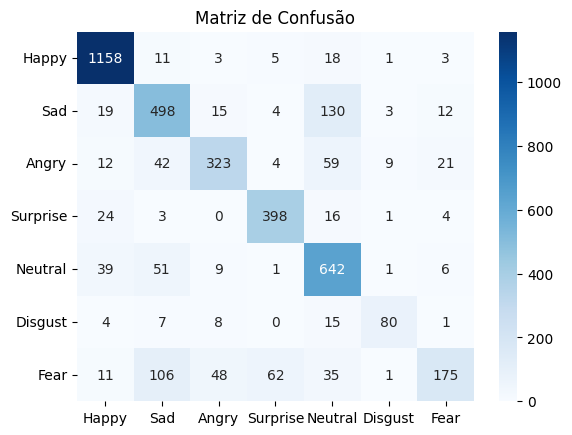

In [ ]:
%pip install seaborn
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusão')

## Testando o modelo

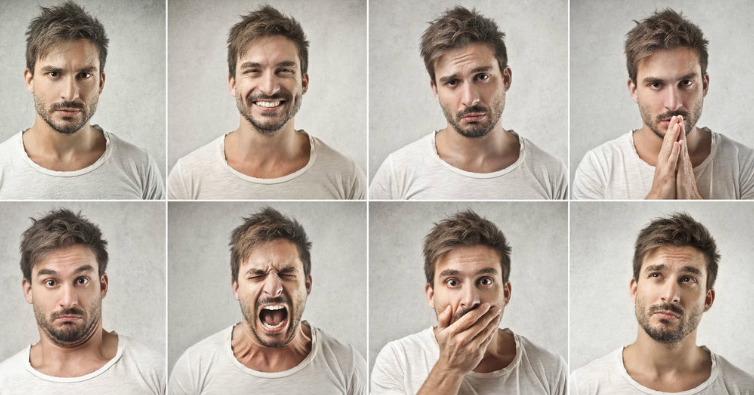

In [ ]:
imagem = cv2.imread('Material/testes/teste02.jpg')
cv2_imshow(imagem)

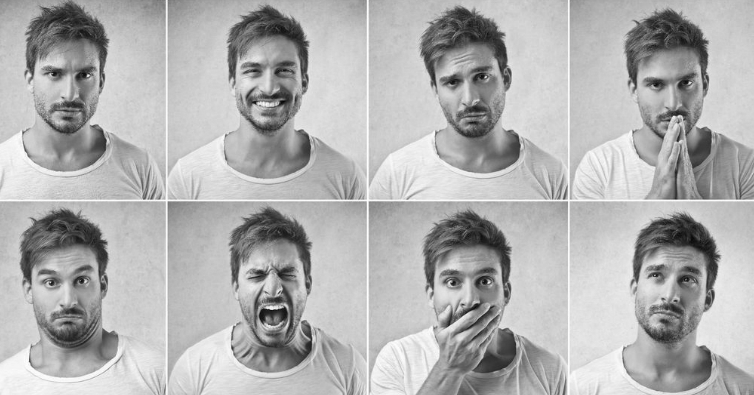

In [ ]:
original = imagem.copy()
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

In [ ]:
# O Cascade Classifier é um classificador em cascata usado para detectar objetos, como rostos, em imagens.
# Nesse caso passamos um modelo já treinado para detectar rostos humanos.
face_cascade = cv2.CascadeClassifier('Material/haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, 1.1, 3)

In [ ]:
faces

array([[224,  35,  90,  90],
       [625,  49,  91,  91],
       [ 23,  41,  92,  92],
       [420,  43,  97,  97],
       [420, 242,  97,  97],
       [ 18, 243,  98,  98],
       [229, 242,  85,  85],
       [627, 241,  91,  91]], dtype=int32)

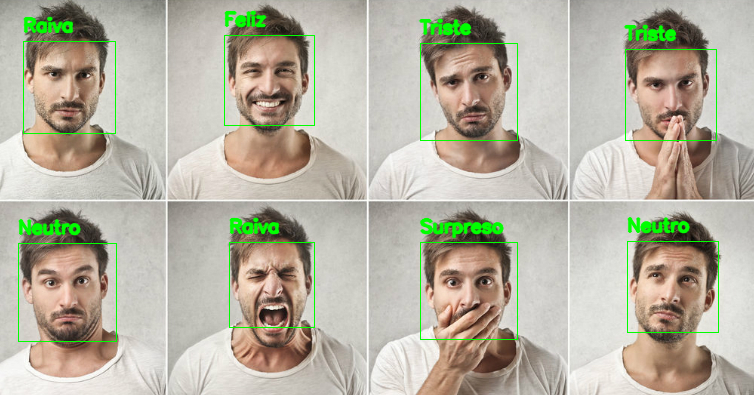

In [ ]:
for (x, y, w, h) in faces:
  cv2.rectangle(original, (x, y), (x + w, y + h), (0, 255, 0), 1)
  roi_gray = gray[y:y + h, x:x + w]
  roi_gray = roi_gray.astype('float') / 255.0
  cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
  prediction = loaded_model.predict(cropped_img)[0]
  cv2.putText(original, expressoes[int(np.argmax(prediction))], (x, y - 10),
              cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)

cv2_imshow(original)